In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import os
import itertools

from multiprocessing import Pool

In [2]:
%run config.py
%run shared.py

In [3]:
valid = pd.read_pickle(PATH_VALID_DEVICES)

# Non-clearable notifications

## Number and percentage of snapshots with non-clearable notifications

**RQ:** How many snapshots do contain a non-clearable notifications?

In [4]:
def contains_non_clearable(lst):
    for n in lst:
        if not n['isClearable']:
            return True
    return False

def worker_sticky_snapshots(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    df['HasNonClearable'] = df.Active.apply(contains_non_clearable)           
    return len(df[df.HasNonClearable])

In [5]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
nc_list = p.map(worker_sticky_snapshots, uuids)

In [6]:
len(nc_list)

3953

In [7]:
print('Number of snapshots with at least one non-clearable notification: %s' % np.sum(nc_list))

Number of snapshots with at least one non-clearable notification: 4537652


In [8]:
print('%s%% of snapshots contained at least one non-clearable notification.' % np.round(np.sum(nc_list) / valid.Count.sum() * 100, 2))

51.39% of snapshots contained at least one non-clearable notification.


## Number of non-clearable notifications per snapshot

**RQ:** What is the percentage of non-clearable notifications?

In [9]:
def count_sticky(lst):
    count = 0
    for n in lst:
        if not n['isClearable']:
            count += 1
    return count

def worker_sticky(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')
    df['ActiveCount'] = df.Active.apply(len)
    df['StickyCount'] = df.Active.apply(count_sticky)
    df['Percentage']  = 0
    
    df.Percentage = df.apply(lambda x: np.nan if x['ActiveCount'] == 0 else x['StickyCount'] / x['ActiveCount'], axis=1)  
    
    df2 = df[['ActiveCount', 'StickyCount', 'Percentage']].copy()
    df2['UUID'] = uuid
    return df2

In [10]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_sticky, uuids)

sticky = pd.concat(lst)
sticky = sticky.reset_index(drop=True)
sticky.tail()

,ActiveCount,StickyCount,Percentage,UUID
8830107,1,0,0.0,device.3952
8830108,0,0,NaN,device.3952
8830109,0,0,NaN,device.3952
8830110,0,0,NaN,device.3952
8830111,2,0,0.0,device.3952


In [11]:
len(sticky.UUID.unique())

3953

In [12]:
len(sticky)

8830112

In [13]:
sticky.describe()

,ActiveCount,StickyCount,Percentage
count,8.830112e+06,8.830112e+06,7.017008e+06
mean,4.624668e+00,9.179454e-01,3.509911e-01
std,7.817107e+00,1.241336e+00,3.811704e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,2.000000e-01
75%,5.000000e+00,1.000000e+00,6.250000e-01
max,1.600000e+02,3.400000e+01,1.000000e+00


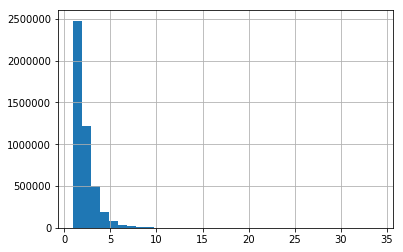

In [14]:
sticky[sticky.StickyCount > 0].StickyCount.hist(bins=int(sticky.StickyCount.max()))

## Unique notifications

**RQ:** How many of the ~11m unique notifications are non-clearable?

In [15]:
def get_notifications(lst):
    result = []
    for n in lst:
        result.append({
            'PackageName': n['packageName'],
            'Id': n['key'] + '@' + str(n['postTime']),
            'Clearable': n['isClearable']
        })
    return result

def worker_sticky_unique(uuid):
    df = pd.read_pickle('%s%s.pkl.gz' % (PATH_DEVICES_DIR, uuid), compression='gzip')   
    result = df.Active.apply(get_notifications).tolist()
    result = list(itertools.chain(*result))
    result = pd.DataFrame(result)
    result = result.groupby('Id', as_index=False).agg(list)
    
    # Some notifications (media?) seem to toggle the clearable-state
    # without re-triggering the notification. For those notifications we
    # see multiple entries with different clearable-states. We simply
    # pick the last state.
    result.Clearable = result.Clearable.apply(lambda x: x[-1])
    result.PackageName = result.PackageName.apply(lambda x: x[-1])
    
    result['UUID'] = uuid
    return result

In [16]:
uuids = valid.UUID.tolist()

p = Pool(NUM_CORES)
lst = p.map(worker_sticky_unique, uuids)

unique = pd.concat(lst)
unique = unique.reset_index(drop=True)
unique.tail()

,Id,Clearable,PackageName,UUID
10928875,key.1437644@1541624736895,False,com.android.systemui,device.3952
10928876,key.1437644@1541769638374,False,com.android.systemui,device.3952
10928877,key.1437645@1541523629135,True,com.android.vending,device.3952
10928878,key.1437645@1541696878386,True,com.android.vending,device.3952
10928879,key.1437646@1541608219788,True,wp.wattpad,device.3952


In [17]:
len(unique.UUID.unique())

3953

In [18]:
len(unique)

10928880

In [19]:
print('Clearable?')
unique.Clearable.value_counts(dropna=False, normalize=True).apply(lambda x: '%s%%' % np.round(x * 100, 2))

Clearable?


True     71.27%
False    28.73%
Name: Clearable, dtype: object

## Packages and categories

In [20]:
pc = unique.copy()
pc.Clearable = pc.Clearable.astype(bool)

pc['Category'] = pc.PackageName.apply(lambda x: category_mapping[x] if x in category_mapping else 'UNKNOWN')

pc.tail()

,Id,Clearable,PackageName,UUID,Category
10928875,key.1437644@1541624736895,False,com.android.systemui,device.3952,SYSTEM
10928876,key.1437644@1541769638374,False,com.android.systemui,device.3952,SYSTEM
10928877,key.1437645@1541523629135,True,com.android.vending,device.3952,SYSTEM
10928878,key.1437645@1541696878386,True,com.android.vending,device.3952,SYSTEM
10928879,key.1437646@1541608219788,True,wp.wattpad,device.3952,MEDIA


### Apps

Clearable:

In [21]:
pc[pc.Clearable].PackageName.value_counts(dropna=False, normalize=True).head(10) \
    .apply(lambda x: '%s%%' % np.round(x * 100, 2))

com.whatsapp                               35.64%
com.google.android.googlequicksearchbox     5.57%
com.instagram.android                       5.26%
com.google.android.gm                       5.26%
com.google.android.apps.maps                2.69%
com.samsung.android.email.provider          2.51%
com.samsung.android.messaging               2.47%
com.android.systemui                        2.45%
com.facebook.katana                         2.44%
com.google.android.youtube                  2.11%
Name: PackageName, dtype: object

Non-clearable:

In [22]:
pc[~pc.Clearable].PackageName.value_counts(dropna=False, normalize=True).head(10) \
    .apply(lambda x: '%s%%' % np.round(x * 100, 2))

android                            18.11%
com.android.systemui               14.33%
com.samsung.android.incallui        3.88%
com.sec.android.app.music           3.69%
com.whatsapp                        3.53%
com.mobilion.diyanet.namazvakit     3.07%
com.mobilexsoft.ezanvakti           2.97%
com.google.android.music            2.39%
com.facebook.orca                   2.18%
com.internet.speed.meter.lite       1.58%
Name: PackageName, dtype: object

### Categories

Clearable:

In [23]:
pc[pc.Clearable].Category.value_counts(dropna=False, normalize=True) \
    .apply(lambda x: '%s%%' % np.round(x * 100, 2))

SMS/IM               44.91%
SOCIAL                10.8%
EMAIL                 9.33%
TOOL                  8.61%
SYSTEM                7.29%
UNKNOWN               4.95%
MEDIA                 3.85%
NAVIGATION            2.78%
PHONE                 2.14%
CALENDAR/REMINDER     1.41%
GAME                  1.31%
NEWS                  1.13%
SHOPPING              1.07%
HEALTH/FITNESS        0.43%
Name: Category, dtype: object

Non-clearable:

In [24]:
pc[~pc.Clearable].Category.value_counts(dropna=False, normalize=True) \
    .apply(lambda x: '%s%%' % np.round(x * 100, 2))

SYSTEM               35.15%
TOOL                 16.13%
UNKNOWN              15.58%
MEDIA                10.77%
PHONE                 9.18%
SMS/IM                6.18%
HEALTH/FITNESS         3.3%
CALENDAR/REMINDER     1.93%
NEWS                  0.98%
NAVIGATION            0.61%
SHOPPING              0.08%
SOCIAL                0.05%
EMAIL                 0.05%
GAME                   0.0%
Name: Category, dtype: object

## Random extra stats

This is not really related to this notebook but here is the categorization coverage of the unique notifications:

In [25]:
print('Categorized unique notifications: %s%%' % np.round(len(pc[pc.Category != 'UNKNOWN']) / len(pc) * 100, 2))
print('Non-categorized unique notifications: %s%%' % np.round(len(pc[pc.Category == 'UNKNOWN']) / len(pc) * 100, 2))

Categorized unique notifications: 92.0%
Non-categorized unique notifications: 8.0%


And here is the number of unique notifications per category:

In [26]:
pc.Category.value_counts().sort_index()

CALENDAR/REMINDER     170284
EMAIL                 728464
GAME                  102164
HEALTH/FITNESS        137404
MEDIA                 637850
NAVIGATION            235631
NEWS                  118797
PHONE                 454586
SHOPPING               85758
SMS/IM               3692077
SOCIAL                843004
SYSTEM               1671025
TOOL                 1177235
UNKNOWN               874601
Name: Category, dtype: int64

Number of unique notifications:

In [27]:
len(pc)

10928880